In [12]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-12-3995005159>:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())

False


In [14]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([.5, .5, .5], [.5, .5, .5])
])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
devtest = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# split the devset into 2 separate sets
randidx = np.random.permutation(10000) # a random permutation of indices
devset = Subset(devtest, randidx[:6000]) # Subset for devset
testset = Subset(devtest, randidx[6000:]) # Subset for test

# transform to dataloaders
batchsize = 32
train_loader = DataLoader(trainset, batch_size=batchsize, shuffle = True, drop_last = True)
dev_loader = DataLoader(devset, batch_size=batchsize) # note: devtest in batches
test_loader = DataLoader(testset, batch_size=len(testset))

In [15]:
# check out the shape of the datasets
print('Data shapes (train/dev/test)')
print(len(trainset))
print(len(devset))
print(len(testset))

# and the range of pixel intensity values
print('\nData value range: ')
print((np.min(trainset.data), np.max(trainset.data)))

# the unique categories
print('\n Data Categories: ')
print(trainset.classes)

Data shapes (train/dev/test)
50000
6000
4000

Data value range: 
(np.uint8(0), np.uint8(255))

 Data Categories: 
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [16]:
X, y = next(iter(train_loader))

print('Data shapes (train/test): ')
print(X.data.shape)

print('\nData value range: ')
print((torch.min(X.data), torch.max(X.data)))

Data shapes (train/test): 
torch.Size([32, 3, 32, 32])

Data value range: 
(tensor(-1.), tensor(1.))


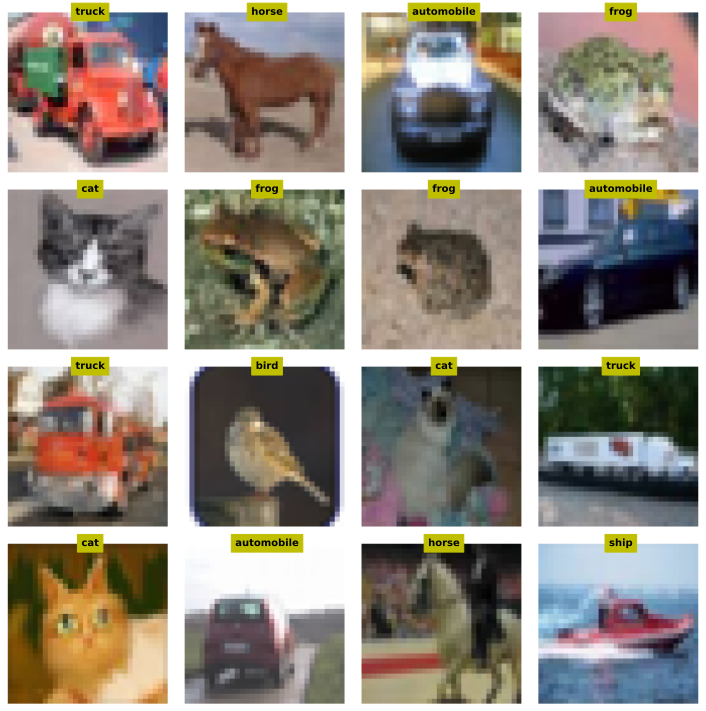

In [17]:
# inspect a few random images
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axs.flatten()):
  # extract that image (need to transpose it back to 32*32*3)
  pic = X.data[i].numpy().transpose((1, 2, 0))
  pic = pic/2 + .5 # undo normalization

  # and it's label
  label = trainset.classes[y[i]]

  ax.imshow(pic)
  ax.text(16, 0, label, ha='center', fontweight = 'bold', color = 'k', backgroundcolor = 'y')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [18]:
# create a class for the model
def makeTheNet(printtoggle=False):

  class cnnnet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      # print toggle
      self.print = printtoggle

      # feature map layers
      # first convolution layer
      self.conv1 = nn.Conv2d(3, 64, 3, padding = 1)
      self.bnorm1 = nn.BatchNorm2d(64) # 64 = input the number of channels in this layer
      # output size: (32+2*1-3)/1 + 1 = 32/2 = 16 (/2 b/c maxpool)

      # second convolution layer
      self.conv2 = nn.Conv2d(64, 128, 3)
      self.bnorm2 = nn.BatchNorm2d(128) # input the number of channels in this layer
      # output size: (16+2*0-3)/1 + 1 = 14/2 = 7 (/2 b/c maxpool)

      # third convolution layer
      self.conv3 = nn.Conv2d(128, 256, 3)
      self.bnorm3 = nn.BatchNorm2d(256) # input the number of channels in this layer
      # output size: (7+2*0-3)/1 + 1 = 5/2 = 2 (/2 b/c maxpool)

      # linear decision layers
      self.fc1 = nn.Linear(2*2*256, 256)
      self.fc2 = nn.Linear(256, 64)
      self.fc3 = nn.Linear(64, 10)

    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      if self.print: print(f'First CPR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # third block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv3(x),2)
      x = F.leaky_relu(self.bnorm3(x))
      if self.print: print(f'Third CPR block: {list(x.shape)}')

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorized: {list(x.shape)}')

      # linear layers
      # training=self.training means to turn off during eval mode
      x = F.leaky_relu(self.fc1(x))
      x = F.dropout(x,p=.5,training=self.training)
      x = F.leaky_relu(self.fc2(x))
      x = F.dropout(x,p=.5,training=self.training)
      x = self.fc3(x)
      if self.print: print(f'Final output: {list(x.shape)}')

      return x

  # create the model instance
  net = cnnnet(printtoggle)

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001,weight_decay=1e-5)

  return net,lossfun,optimizer

In [19]:
# test the model with one batch
net, lossfun, optimizer = makeTheNet(True)

X, y = next(iter(train_loader))
yHat = net(X)

# check sizes of model outputs and target variable
print(" ")
print(yHat.shape)
print(y.shape)

# now let's compute the loss
loss = lossfun(yHat, torch.squeeze(y))
print(" ")
print("Loss: ")
print(loss)

Input: [32, 3, 32, 32]
First CPR block: [32, 64, 16, 16]
Second CPR block: [32, 128, 7, 7]
Third CPR block: [32, 256, 2, 2]
Vectorized: [32, 1024]
Final output: [32, 10]
 
torch.Size([32, 10])
torch.Size([32])
 
Loss: 
tensor(2.2649, grad_fn=<NllLossBackward0>)


In [20]:
# a function that trains the model

def trainTheModel():

    # number of epochs
    numepochs = 10

    # create a new model
    net, lossfun, optimizer = makeTheNet()

    # send the model to the GPU
    net.to(device)

    # initialize losses
    trainLoss = torch.zeros(numepochs)
    devLoss = torch.zeros(numepochs)
    trainAcc = torch.zeros(numepochs)
    devAcc = torch.zeros(numepochs)

    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        net.train() # switch to train mode
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # push data to the GPU
            X = X.to(device)
            y = y.to(device)

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())
            batchAcc.append(torch.mean((torch.argmax(yHat, axis = 1) == y).float()).item())
        # end loop

        # now that we've trained through the batches, get avg training accuracy
        trainLoss[epochi] = np.mean(batchLoss)
        trainAcc[epochi] = 100*np.mean(batchAcc)

        # test accuracy
        net.eval() # switch to test mode
        batchAcc = []
        batchLoss = []
        for X, y in dev_loader:

            # push data to GPU
            X = X.to(device)
            y = y.to(device)

            with torch.no_grad():
                yHat = net(X)
                loss = lossfun(yHat, y)

            # loss and accuracy from this batch
            batchLoss.append(loss.item())
            batchAcc.append(torch.mean((torch.argmax(yHat, axis = 1) == y).float()).item())

        # compute test accuracy
        devLoss[epochi] = np.mean(batchLoss)
        devLoss[epochi] = 100*np.mean(batchAcc)

    # end epochs

    # function output
    return trainLoss, devLoss, trainAcc, devAcc, net

In [21]:
trainLoss, devLoss, trainAcc, devAcc, net = trainTheModel()

In [22]:
# the real test set

net.eval() # switch to test mode
X, y = next(iter(test_loader))

# push data to GPU
X = X.to(device)
y = y.to(device)

# forward pass and loss
with torch.no_grad():
  yHat = net(X)
  loss = lossfun(yHat, y)

# loss and accuracy from this batch
testLoss = loss.item()
testAcc = torch.mean((torch.argmax(yHat, axis = 1) == y).float()).item()

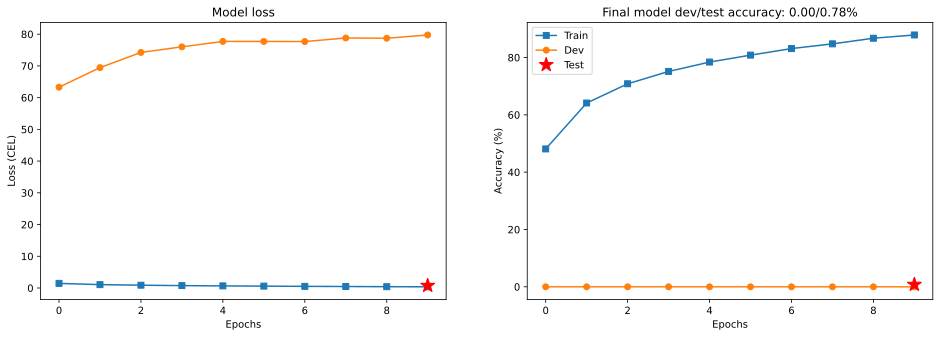

In [24]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(devLoss,'o-',label='Dev')
ax[0].plot(len(devLoss)-1,testLoss,'r*',markersize=15,label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CEL)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(devAcc,'o-',label='Dev')
ax[1].plot(len(devAcc)-1,testAcc,'r*',markersize=15,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model dev/test accuracy: {devAcc[-1]:.2f}/{testAcc:.2f}%')
ax[1].legend()

plt.show()